In [3]:
# Week 1: Expense Categorization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (using relative path from notebooks directory)
df = pd.read_csv('../data/expenses.csv')

# Peek at the data
print("First few rows:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")

# Basic info
print("\n" + "="*50)
print("Dataset Info:")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("Category Distribution:")
print("="*50)
print(df['category'].value_counts())

First few rows:
  expense_id  amount     merchant      description       category
0       EXP1   78.04       Amazon    fuel purchase       shopping
1       EXP2  190.39  Apple Store  online shopping     technology
2       EXP3  147.74   McDonald's     app purchase           food
3       EXP4  121.74    Starbucks             meal           food
4       EXP5   35.42      Netflix    fuel purchase  entertainment

Dataset shape: (100, 5)

Column names: ['expense_id', 'amount', 'merchant', 'description', 'category']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   expense_id   100 non-null    object 
 1   amount       100 non-null    float64
 2   merchant     100 non-null    object 
 3   description  100 non-null    object 
 4   category     100 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.0+ KB
None

Category Distr

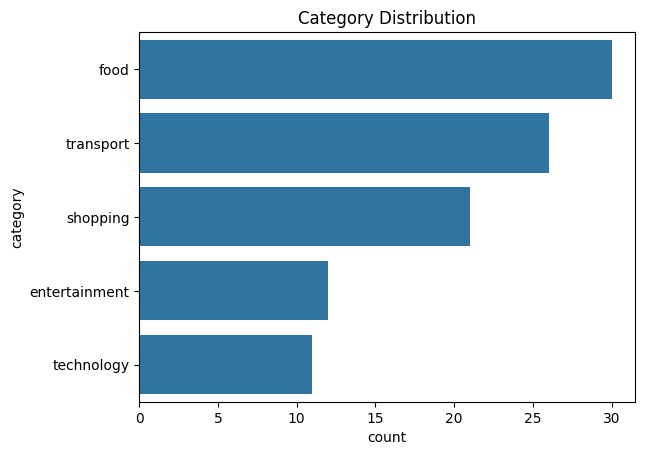

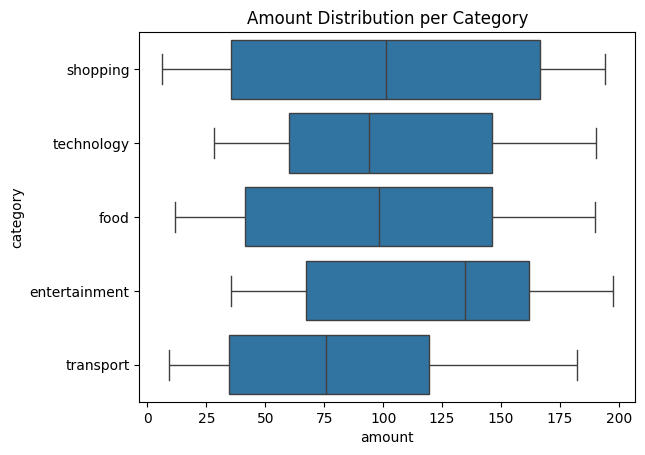

        amount
amount     1.0


In [4]:
# Category distribution
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Category Distribution')
plt.show()

# Amount by category
sns.boxplot(x='amount', y='category', data=df)
plt.title('Amount Distribution per Category')
plt.show()

# Correlation (numerical only)
print(df.corr(numeric_only=True))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Features and target
# Use .copy() to explicitly create a copy and avoid SettingWithCopyWarning
X = df[['description', 'amount']].copy()  # Add more if available (e.g., 'date' → extract day/month)
y = df['category'].copy()

# Handle missing text - now safe to modify since X is an explicit copy
X['description'] = X['description'].fillna('missing')

# Train-test split (stratify for imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessor: TF-IDF for text + scale numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'description'),  # Limit vocab for speed
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), ['amount'])
    ])

# Apply (for exploration)
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(X_train_preprocessed.shape)  # Sparse matrix: rows x features

(80, 12)


In [7]:
# Extract from date if column exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    # Add to X: 'month', 'day_of_week' as numerical/categorical

               precision    recall  f1-score   support

entertainment       0.50      0.33      0.40         3
         food       0.67      0.33      0.44         6
     shopping       1.00      0.25      0.40         4
   technology       0.09      0.50      0.15         2
    transport       0.33      0.20      0.25         5

     accuracy                           0.30        20
    macro avg       0.52      0.32      0.33        20
 weighted avg       0.57      0.30      0.35        20

Accuracy: 0.30


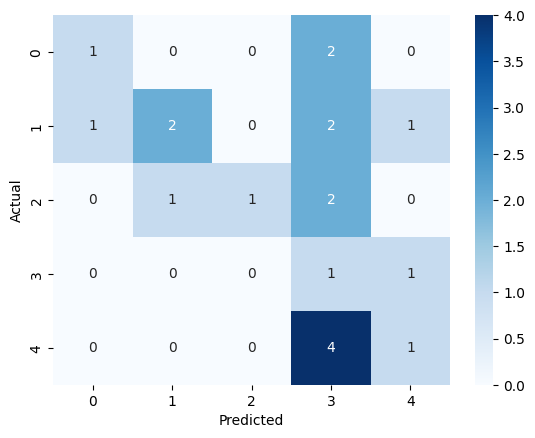

CV F1-Macro: 0.18


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Full pipeline
# Note: LogisticRegression handles multi-class automatically (default solver='lbfgs' supports it)
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
    # Or try RandomForestClassifier(class_weight='balanced')
])

# Train
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

# Confusion matrix viz
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# CV
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='f1_macro')
print(f'CV F1-Macro: {cv_scores.mean():.2f}')

In [12]:
# Synthetic fallback if needed
from faker import Faker
fake = Faker()
categories = ['Groceries', 'Dining Out', 'Transport', 'Entertainment', 'Utilities', 'Healthcare']
data = [{'description': fake.company() if i%2==0 else fake.bs(), 'amount': fake.pydecimal(2,2,True), 'category': fake.random_element(categories)} for i in range(5000)]
df = pd.DataFrame(data)
# Use relative path from notebooks directory (go up one level to access data/)
df.to_csv('../data/synthetic_expenses.csv', index=False)